In [65]:
import functools
from functools import partial
import itertools
import logging
import math
import os
import pickle
import sys
from pathlib import Path

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import pingouin as pg
import seaborn as sns
import yaml
#import pingouin as pg

%load_ext autoreload
%autoreload 2

%matplotlib inline

sns.set_context("poster")
sns.set(rc={"figure.figsize": (16, 12.0)})
sns.set_style("whitegrid")

import numpy as np
import pandas as pd
from scipy.stats import kendalltau, rankdata, spearmanr, pearsonr, ttest_rel
import torch.nn.functional as F

pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)

logging.basicConfig(level=logging.INFO, stream=sys.stdout)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [192]:
from lda4rec.datasets import Interactions, DataLoader, random_train_test_split, MOVIELENS_1M,MetaData, get_dataset, items_per_user_train_test_split
from lda4rec.evaluations import summary
from lda4rec.estimators import MFEst, PopEst, LDA4RecEst, SNMFEst
from lda4rec.utils import process_ids, cmp_ranks, dist_overlap, norm_entropy, Config, apply_along_dim
from lda4rec import lda

In [67]:
import pyro
import pyro.distributions as dist
import pyro.optim as optim
import torch
from pyro.distributions import constraints
from pyro.infer import SVI, Predictive, Trace_ELBO, TraceEnum_ELBO, config_enumerate

In [68]:
import neptune.new as neptune
# init dummy neptune to avoid problems with logging
neptune.init(mode='offline') 

offline/af3dec97-0be6-4f97-910b-8c6b2c34bf6f
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


In [69]:
from icecream import ic, install

install()
# configure icecream
def ic_str(obj):
    if hasattr(obj, "shape"):
        return f"{obj} "  #
    else:
        return str(obj)

In [70]:
ic.configureOutput(argToStringFunction=ic_str)

## Interpretation

In [71]:
md = MetaData.from_movielens_1m()

In [72]:
cfg = Config(Path('../configs/exp_25.yaml'))
exp_cfg = cfg["experiment"]

In [73]:
exp_cfg

{'dataset': 'movielens-1m',
 'dataset_seed': 1729,
 'est_params': {'batch_size': 256,
  'embedding_dim': 16,
  'learning_rate': 0.001,
  'n_iter': 200},
 'estimator': 'MFEst',
 'interaction_pivot': 0,
 'max_user_interactions': 200,
 'min_user_interactions': 20,
 'model_seed': 1981,
 'train_test_split': 'random_train_test_split'}

In [187]:
data = get_dataset("goodbooks")

In [197]:
data.min_user_interactions_(29)

array([ 6852,  7850,  9407,  9665, 10444, 11130, 11206, 11354, 12701,
       13339, 14047, 15116, 15188, 15703, 16160, 16385, 17670, 18753,
       19779, 22238, 23789, 23975, 24300, 24700, 24774, 24933, 24936,
       25456, 26100, 26220, 26433, 26489, 26514, 26915, 27214, 27813,
       28281, 29126, 29371, 29496, 29582, 29607, 29856, 30054, 30179,
       30233, 30247, 30570, 30817, 30845, 31904, 32261, 32455, 32535,
       32810, 32819, 32940, 33040, 33124, 34007, 34066, 34434, 34546,
       34685, 34691, 34704, 35131, 35411, 35421, 35863, 36226, 36318,
       36399, 36480, 36541, 36646, 37441, 37500, 37589, 37713, 37926,
       38534, 40049, 40315, 40724, 40820, 40921, 41023, 41243, 41380,
       41410, 41429, 41745, 41912, 42079, 42300, 42418, 42879, 43111,
       43896, 43942, 44212, 44927, 45102, 45207, 46060, 46619, 46683,
       46743, 46766, 46768, 47461, 47748, 48237, 48324, 48625, 48665,
       49024, 49189, 49292, 49373, 49689, 49855, 50528, 50662, 50924,
       51723, 51848,

In [198]:
items_per_user_train_test_split(data, 19)

(<Interactions dataset (53424 users x 10000 items x 4960557 interactions)>,
 <Interactions dataset (53424 users x 10000 items x 1012586 interactions)>)

In [200]:
1012586 / 4960557

0.20412748003903594

In [188]:
data.n_users

53424

In [208]:
data_rng = np.random.default_rng(exp_cfg["dataset_seed"])
data = get_dataset(exp_cfg["dataset"], data_dir=cfg["main"]["data_path"])
data.implicit_(exp_cfg["interaction_pivot"])  # implicit feedback
#data.max_user_interactions_(exp_cfg["max_user_interactions"], rng=data_rng)
data.min_user_interactions_(29)

array([   3,   11,   13,   19,   20,   40,   42,   46,   54,   63,   65,
         88,   93,   97,  123,  127,  140,  151,  152,  157,  159,  163,
        167,  170,  171,  196,  199,  206,  208,  212,  216,  225,  226,
        249,  253,  275,  276,  282,  297,  303,  310,  312,  314,  316,
        317,  319,  340,  344,  352,  355,  360,  363,  366,  372,  382,
        383,  394,  416,  420,  426,  447,  454,  467,  487,  488,  490,
        496,  501,  510,  526,  534,  558,  564,  567,  571,  573,  577,
        588,  591,  598,  599,  606,  616,  618,  639,  641,  652,  664,
        685,  702,  707,  718,  722,  744,  750,  760,  762,  770,  774,
        781,  789,  820,  826,  832,  834,  840,  873,  897,  899,  901,
        905,  906,  931,  940,  941,  946,  950,  968,  985, 1038, 1045,
       1069, 1082, 1101, 1125, 1143, 1153, 1156, 1165, 1170, 1173, 1188,
       1189, 1196, 1212, 1224, 1225, 1233, 1235, 1248, 1249, 1281, 1304,
       1306, 1308, 1309, 1317, 1318, 1335, 1345, 13

In [209]:
items_per_user_train_test_split(data, 19)

(<Interactions dataset (6040 users x 3706 items x 882268 interactions)>,
 <Interactions dataset (6040 users x 3706 items x 101859 interactions)>)

In [210]:
101859 / 882268

0.11545131411317196

In [186]:
data.n_users

6040

In [75]:
train, rest = random_train_test_split(data, test_percentage=0.10, rng=data_rng)
test, valid = random_train_test_split(rest, test_percentage=0.5, rng=data_rng)

In [76]:
est = MFEst(**exp_cfg["est_params"])
est.load("../models/exp_25_MFEst_2021-12-28_18:02:01.model", data)

<MFEst: MFNet(
  (user_embeddings): ScaledEmbedding(6040, 16)
  (item_embeddings): ScaledEmbedding(3706, 16)
  (item_biases): ZeroEmbedding(3706, 1)
)>

In [77]:
v, t, h, b = est.get_lda_params()

## Cohort overlap of N most likely values of different cohorts

In [78]:
def cohort_overlap_top_n(cohorts, n=10):
    n_cohorts = cohorts.shape[1]
    top_n = [set(c.argsort(descending=True)[:n].numpy()) for c in torch.unbind(cohorts, dim=1)]
    return np.array([[len(top_n[i] & top_n[j]) / n for j in np.arange(n_cohorts)] for i in np.arange(n_cohorts)])

<AxesSubplot:ylabel='Count'>

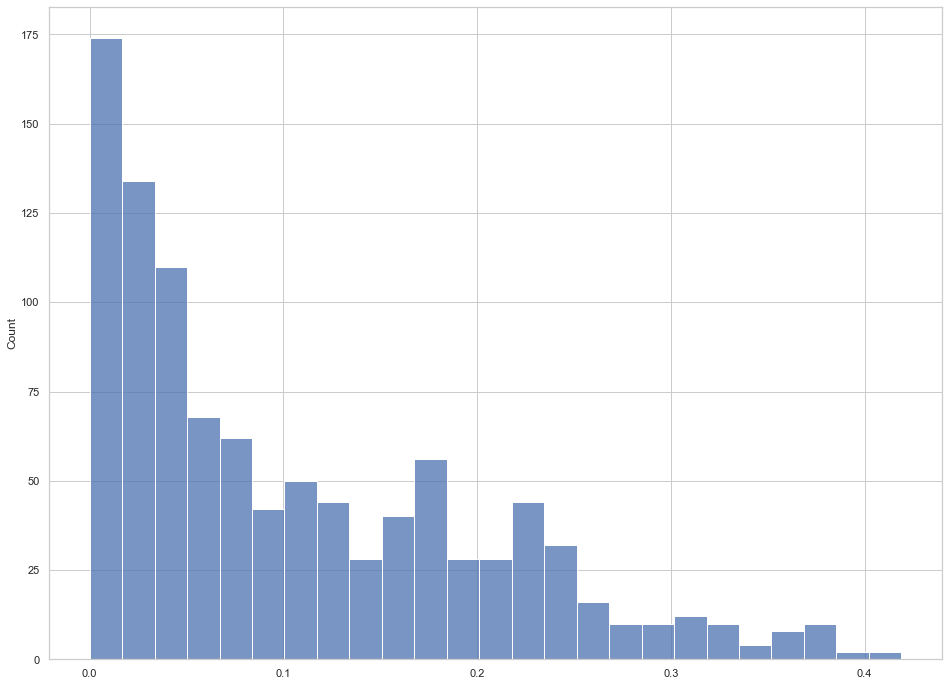

In [79]:
overlap = cohort_overlap_top_n(h, n=370)
d0_overlap = overlap.copy()
np.fill_diagonal(d0_overlap, 0)
sns.histplot(d0_overlap.flatten(), bins=25)

Rank der top N besser.

<AxesSubplot:>

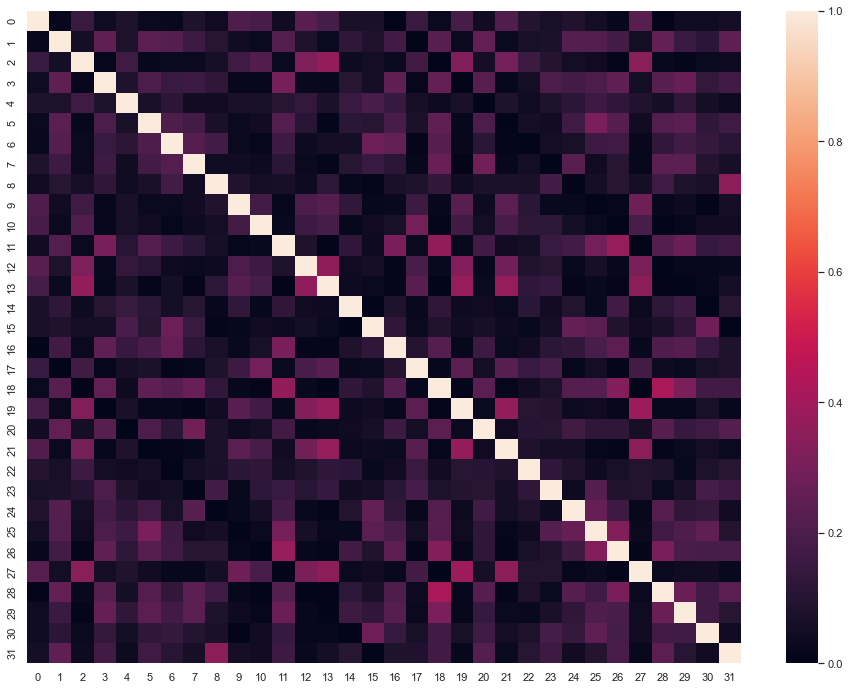

In [80]:
sns.heatmap(overlap)

In [81]:
def cohort_kendall_tau(cohorts):
    n_cohorts = cohorts.shape[1]
    return np.array([[kendalltau(c.numpy(), d.numpy(), variant='c').correlation for d in torch.unbind(cohorts, dim=1)] for c in torch.unbind(cohorts, dim=1)])

In [82]:
ctaus = cohort_kendall_tau(h)

<AxesSubplot:ylabel='Count'>

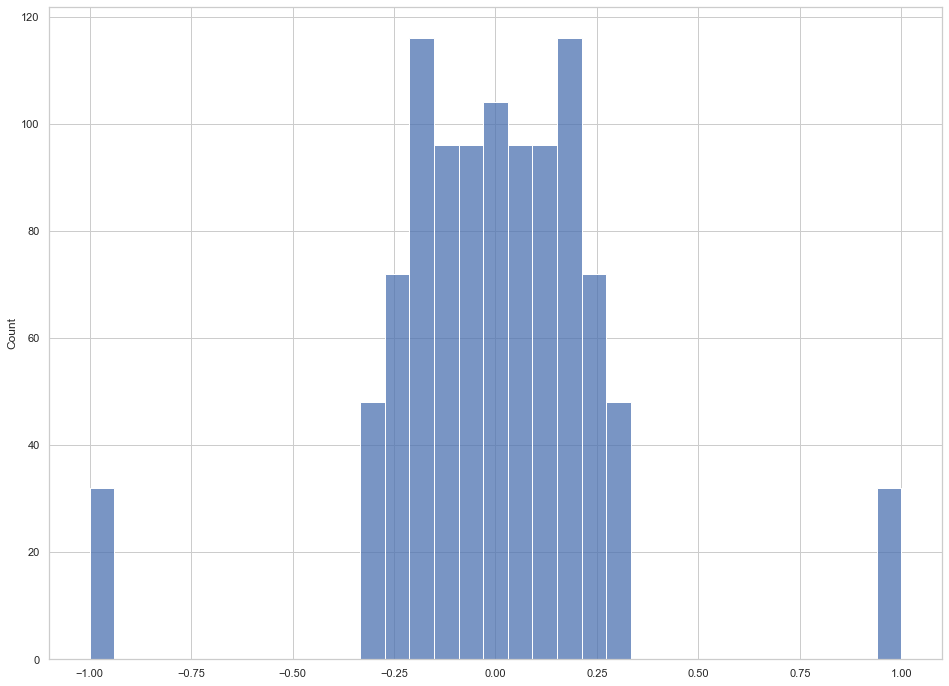

In [83]:
sns.histplot(ctaus.flatten())

In [84]:
kendalltau(torch.unbind(h, dim=1)[0], torch.unbind(h, dim=1)[0])

KendalltauResult(correlation=1.0, pvalue=0.0)

In [85]:
kendalltau(np.array([1,2]), np.array([2,1]))

KendalltauResult(correlation=-1.0, pvalue=1.0)

In [86]:
def cohort_kendalltau_top_n(cohorts, n=10, p=0.05):
    n_cohorts = cohorts.shape[1]
    top_n = [c.argsort(descending=True)[:n].numpy() for c in torch.unbind(cohorts, dim=1)]
    overlap = [[np.array(list(set(top_n[i]) & set(top_n[j]))) for j in np.arange(n_cohorts)] for i in np.arange(n_cohorts)]
    corr_pval = np.array([[kendalltau(cohorts[:, i][overlap[i][j]], cohorts[:, j][overlap[i][j]]) for j in np.arange(n_cohorts)] for i in np.arange(n_cohorts)])
    corr, pval = corr_pval[..., 0], corr_pval[..., 1] 
    corr[pval > p] = np.nan
    return corr

In [87]:
cohort_kendalltau_top_n(h, n=1000)

array([[ 1.        ,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,  1.        ,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,  1.        , ...,         nan,
                nan,         nan],
       ...,
       [        nan,         nan,         nan, ...,  1.        ,
                nan, -0.09798265],
       [        nan,         nan,         nan, ...,         nan,
         1.        ,         nan],
       [        nan,         nan,         nan, ..., -0.09798265,
                nan,  1.        ]])

<AxesSubplot:>

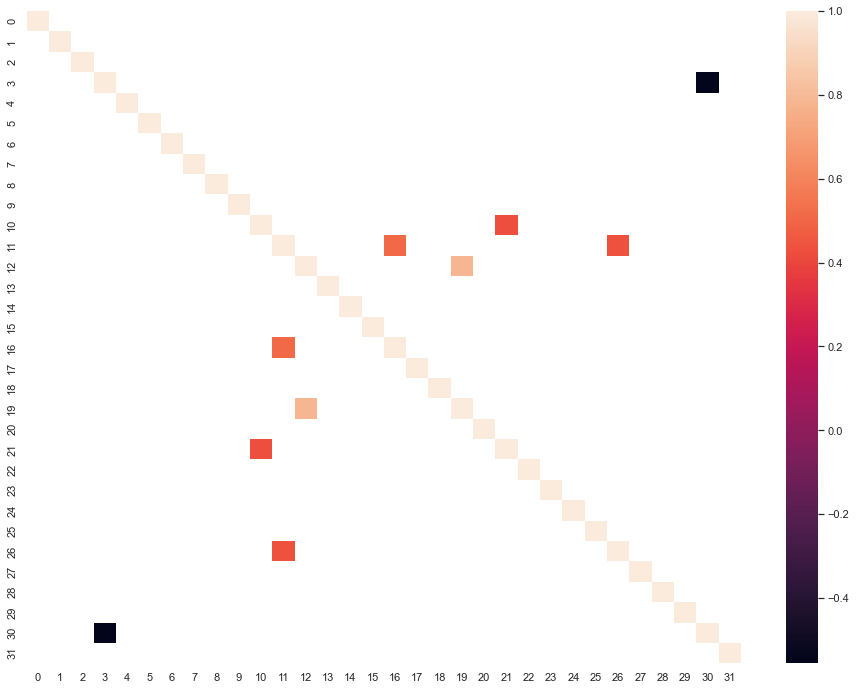

In [88]:
sns.heatmap(cohort_kendalltau_top_n(h, n=100, p=0.05))

In [89]:
N = 4
kendalltau(np.arange(N), np.arange(N))

KendalltauResult(correlation=1.0, pvalue=0.08333333333333333)

<AxesSubplot:ylabel='Count'>

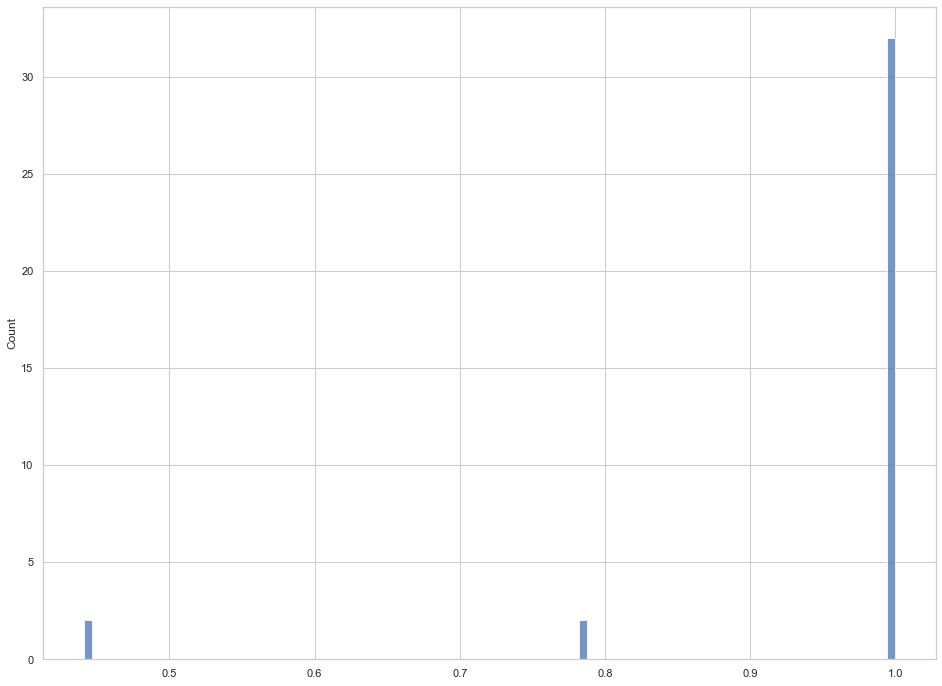

In [90]:
sns.histplot(cohort_kendalltau_top_n(h, n=100, p=0.01).flatten(), bins=100)

## General overlap of the cohorts

In [91]:
N = h.shape[1]
res = [dist_overlap(h[:,i], h[:,j])  for i in range(N) for j in range(N) if j > i]

In [92]:
min(res), max(res)

(0.7067843675613403, 0.8785260915756226)

## N most importants items of a cohort

In [93]:
def n_most_important_items_per_cohort(cohorts, metadata, n=10):
    c_items = [c.argsort(descending=True)[:n].numpy() for c in torch.unbind(cohorts, dim=1)]
    return [list(map(lambda x: metadata.item_info(x)['name'], items)) for items in c_items]

In [94]:
#n_most_important_items_per_cohort(h, md)

## Popularity Comparison

In [95]:
df = data.to_pandas()

In [96]:
emp_pops = np.zeros(data.n_items, dtype=int)

In [97]:
val_counts = df['item_id'].value_counts()

In [98]:
emp_pops[val_counts.index] = val_counts.to_numpy()

In [99]:
kendalltau(emp_pops, b)

KendalltauResult(correlation=0.6504477054053043, pvalue=0.0)

Quite strong according to http://polisci.usca.edu/apls301/Text/Chapter%2012.%20Significance%20and%20Measures%20of%20Association.htm

## Conformity to Popularity

In [100]:
def kendalltau_pop_conf(pop, confs, data, kind=kendalltau):
    df = data.to_pandas()
    user_interaction_pops = df.groupby('user_id').apply(lambda grp: np.median(pop[grp['item_id'].values]))
    return kind(user_interaction_pops.values, confs[user_interaction_pops.index].flatten())

In [101]:
pearsonr(np.arange(10), np.arange(10))

(1.0, 0.0)

In [102]:
kendalltau_pop_conf(emp_pops, (1/t).numpy(), train)

KendalltauResult(correlation=0.22287534063143916, pvalue=1.5350021263539814e-148)

In [103]:
kendalltau_pop_conf(b, 1/t, train)

KendalltauResult(correlation=0.37821606157205484, pvalue=0.0)

do this on test set!

## Belonging to different cohorts

In [104]:
df = train.to_pandas()

In [105]:
def get_cohorts(cohorts, df):
    n_cohorts = cohorts.shape[1]
    items = df['item_id'].to_numpy()
    cohorts = np.array([cohorts[i].argmax() for i in items])
    counts = np.zeros(n_cohorts)
    nums, n_counts = np.unique(cohorts, return_counts=True)
    counts[nums] = n_counts / n_counts.sum()
    return counts
    
res = df.groupby('user_id', as_index=False).apply(partial(get_cohorts, h))

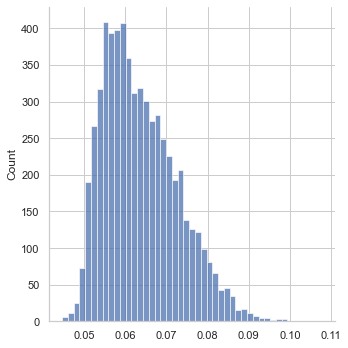

In [106]:
sns.displot((1/t).squeeze())

In [107]:
threshold = (1/t).squeeze().median()
mask = (1/t < threshold).squeeze().numpy()

In [108]:
dist_ovs = res.to_frame().apply(lambda x: dist_overlap(torch.tensor(x[0]), v[x.name]), axis=1)

In [109]:
dist_ovs.loc[~mask].mean()

0.6071922800116386

In [110]:
dist_ovs.loc[mask].std()

0.06619406114428626

In [111]:
dist_ovs.loc[~mask]

1       0.587951
2       0.621141
3       0.446030
7       0.631141
11      0.533376
          ...   
6030    0.517559
6031    0.780629
6032    0.594276
6033    0.513614
6037    0.726419
Length: 3021, dtype: float64

In [112]:
dist_df = pd.DataFrame(dict(overlap=dist_ovs.to_numpy(), conformity=(1/t).numpy().flatten(), low=mask))

In [113]:
#dist_df = dist_df.loc[(dist_df['conformity'] < 0.05) | (dist_df['conformity'] > 0.08)]

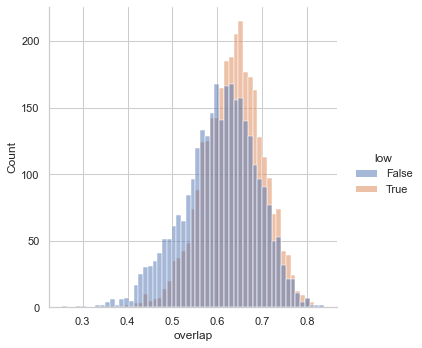

In [114]:
sns.displot(dist_df, x='overlap', hue='low')

## User Finger Printing and comparison

In [115]:
def tee(it):
    for e in it:
        print(e)
        yield e

In [116]:
def find_twins(users, n=None):
    twins = []
    for user_id in np.arange(users.shape[0])[:n]:
        neighbors = apply_along_dim(users, partial(dist_overlap, v[user_id]), dim=0)
        neighbors[user_id] = 0.0 # eliminate itself
        twins.append(neighbors.argmax().item())                            
                                    
    return np.array(twins)

In [117]:
def plot_cat(dist):
    sns.barplot(x=np.arange(dist.shape[0]), y=dist.numpy())

In [123]:
good_twins = find_twins(v)

In [124]:
bad_twins = np.random.randint(v.shape[0], size=v.shape[0])

In [125]:
df = data.to_pandas().set_index('user_id')

In [174]:
def get_good_bad_jacs(good, bad, data):
    # do this here for random users
    assert good.shape == bad.shape
    
    df = data.to_pandas().set_index('user_id')
    good_jac = []
    bad_jac = []
    for user_id in range(good.shape[0]):
        print(user_id)
        orig_items = set(df['item_id'].loc[[user_id]].values)
        good_items = set(df['item_id'].loc[[good[user_id]]].values)
        print(df['item_id'].loc[bad[user_id]])
        bad_items = set(df['item_id'].loc[[bad[user_id]]].values)
        good_jac.append(len(orig_items & good_items) / len(orig_items | good_items))
        bad_jac.append(len(orig_items & bad_items) / len(orig_items | bad_items))
    
    return np.array(good_jac), np.array(bad_jac)

In [180]:
df = test.to_pandas().set_index('user_id')

In [181]:
bad_twins[2]

2607

paired t-test

In [189]:
ttest_rel(good_jacs[:1000], bad_jacs[:1000])

Ttest_relResult(statistic=34.15496397334395, pvalue=5.029080968936296e-170)

In [190]:
pg.ttest(good_jacs, bad_jacs, paired=True)

/Users/fwilhelm/.mambaforge/envs/lda4rec-ng/lib/python3.8/site-packages/pingouin/bayesian.py:146: RuntimeWarning: divide by zero encountered in double_scalars
  bf10 = 1 / ((1 + t**2 / df)**(-(df + 1) / 2) / integr)


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,83.044131,6039,two-sided,0.0,"[0.08, 0.09]",1.445248,inf,1.0
